In [253]:
# Import modules
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import platform

In [255]:
# Environment/Package version logging for reproducibility.
# This cell logs the current environment and Python package versions for transparency and reproducibility.
print(f"Python Version: {platform.python_version()}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")

Python Version: 3.11.3
Pandas Version: 2.2.3
Matplotlib Version: 3.10.0


In [48]:
# Get the base directory (current working directory)
base_dir = os.getcwd()

In [31]:
# Set relative paths
heat_wave_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "heat_wave_library", "With_spatial_coverage"))
cold_snap_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "cold_snap_library", "With_spatial_coverage"))

In [192]:
# Define the custom colors and line styles for the plots
custom_colors = [
    '#a3e4a7',  # Def 1: very light green for >90th
    '#32cd32',  # Def 2: light green for >95th
    '#228b22',  # Def 3: darker green for >98th
    '#006400',  # Def 4: darkest green for >99th
    '#ff1a1a',  # Def 5: dark red for > 95th
    '#800000',  # Def 6: darkest red for >97.5th + >81th
    '#ff9999',  # Def 7: light red for >90th + >75th
    '#ffcccc',  # Def 8: lightest red for >90th
    '#4682b4',  # Def 9: medium blue for >95th
    '#00008b',  # Def 10: darkest blue for >97.5th + >81th
    '#87cefa',  # Def 11: lighter blue for >90th + >75th
    '#b3d9ff',  # Def 12: lightes blue for > 90th
]

# Define the line styles based on the thresholds logic
linestyles = [
    '-',   # Def 1-4: Solid line for single threshold
    '-', 
    '-', 
    '-', 
    '-',   # Def 5: Solid line for single threshold
    '--',  # Def 6: Dashed line for two thresholds
    '--',  # Def 7: Dashed line for two thresholds
    'dotted',  # Def 8: Dotted line for moving window
    '-',   # Def 9: Solid line for single threshold 
    '--',  # Def 10: Dashed line for two thresholds 
    '--',  # Def 11: Dashed line for two thresholds 
    'dotted',  # Def 12: Dotted line for moving window 
]


# Over view of the workflow
This script read in heat wave/cold snap event library (based on area-weighted and pop-weighted aggregation methods) and then plot the event characteristics, including event intensity, frequency, duration, and spatial coverage

In [221]:
# Function definitions for repeated tasks

def extract_number(s):
    """
    Define the function to extract numbers
    """
    return re.findall(r'\d+', s)[0]

def get_sorted_file_list(directory, keyword, extension=".csv"):
    """
    Utility function to list and sort files in a given directory based on a keyword and extension.
    """
    files = [file for file in os.listdir(directory) if keyword in file and file.endswith(extension)]
    return sorted(files, key=lambda name: int(re.search(r'\d+', name).group()))

def load_and_label_data(file_list, path, label_prefix):
    """
    Utility function to load CSV files into DataFrames and add a label column.
    """
    dfs = []
    for i, filename in enumerate(file_list, start=1):
        full_path = os.path.join(path, filename)
        df = pd.read_csv(full_path)
        df["definition"] = f"{label_prefix} {i}"
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def group_and_sort_data(data, group_by_column, index_column_name, calculate_column=None, operation='mean', fill_value=0):
    """
    Groups a DataFrame by 'group_by_column' and 'index_column_name', applies an operation ('mean' or 'count') on 
    'calculate_column', ensures the correct matrix orientation, and sorts rows and columns.

    Parameters:
        - data (pd.DataFrame): Input DataFrame.
        - group_by_column (str): Column name to group by (e.g., "definition").
        - index_column_name (str): The column used for grouping along with 'group_by_column' (e.g., "NERC_ID").
        - calculate_column (str, optional): Column to apply the operation ('mean') on (ignored for 'count').
        - operation (str): Operation to perform; supported values are 'mean' and 'count'.
        - fill_value (int): Value to fill missing entries with (default is 0).
    
    Returns:
        - Grouped and sorted DataFrame with the correct orientation.
    """
    # Perform grouping and calculate based on the operation
    if operation == 'mean' and calculate_column:
        # Ensure grouping and mean calculation with correct unstack level
        grouped = data.groupby([index_column_name, data[group_by_column]])[calculate_column].mean().unstack(level=1)
    elif operation == 'count':
        # Group and count events, unstack using level=1 to ensure correct orientation
        grouped = data.groupby([index_column_name, data[group_by_column]]).size().unstack(level=1, fill_value=fill_value)
    else:
        raise ValueError("Invalid operation or missing calculate_column for 'mean'.")

    # Sort columns and rows based on numeric value
    grouped = grouped.reindex(sorted(grouped.columns, key=lambda x: int(re.search(r'\d+', str(x)).group())), axis=1)
    grouped = grouped.reindex(sorted(grouped.index, key=lambda x: int(re.search(r'\d+', str(x)).group())))

    return grouped


In [223]:
# Load and sort filenames for heat wave and cold snap data.
# These steps load the file names for heat wave and cold snap data using reusable functions.
filenames_hw_area = get_sorted_file_list(heat_wave_path, "average_area")
filenames_hw_pop = get_sorted_file_list(heat_wave_path, "average_pop")

filenames_cs_area = get_sorted_file_list(cold_snap_path, "average_area")
filenames_cs_pop = get_sorted_file_list(cold_snap_path, "average_pop")

In [225]:
# Loading and labeling data with reusable function.
# This step reads the CSV files into DataFrames and labels them according to the definition.
all_hw_area = load_and_label_data(filenames_hw_area, heat_wave_path, "Definition")
all_hw_pop = load_and_label_data(filenames_hw_pop, heat_wave_path, "Definition")

all_cs_area = load_and_label_data(filenames_cs_area, cold_snap_path, "Definition")
all_cs_pop = load_and_label_data(filenames_cs_pop, cold_snap_path, "Definition")

In [226]:
# Convert centroid_date column to datetime
all_hw_area["centroid_date"] = pd.to_datetime(all_hw_area["centroid_date"])
all_hw_pop["centroid_date"] = pd.to_datetime(all_hw_pop["centroid_date"])

all_cs_area["centroid_date"] = pd.to_datetime(all_cs_area["centroid_date"])
all_cs_pop["centroid_date"] = pd.to_datetime(all_cs_pop["centroid_date"])

In [227]:
# Convert temperature from Kelvin to degree Celcius
all_hw_area['highest_temperature'] = all_hw_area['highest_temperature'] - 273.15
all_hw_pop['highest_temperature'] = all_hw_pop['highest_temperature'] - 273.15

all_cs_area['lowest_temperature'] = all_cs_area['lowest_temperature'] - 273.15
all_cs_pop['lowest_temperature'] = all_cs_pop['lowest_temperature'] - 273.15

# Plot for event intensity (highest/lowest temperature)

In [236]:
# Grouping, calculating mean of highest/lowest temperature, and sorting for each dataset
grouped_hw_area = group_and_sort_data(all_hw_area, group_by_column='definition',
                                      index_column_name = "NERC_ID", 
                                      calculate_column='highest_temperature', 
                                      operation="mean")

grouped_hw_pop = group_and_sort_data(all_hw_pop, group_by_column='definition', 
                                     index_column_name='NERC_ID', 
                                     calculate_column='highest_temperature', 
                                     operation="mean")

grouped_cs_area = group_and_sort_data(all_cs_area, group_by_column='definition', 
                                      index_column_name='NERC_ID', 
                                      calculate_column='lowest_temperature', 
                                      operation="mean")

grouped_cs_pop = group_and_sort_data(all_cs_pop, group_by_column='definition', 
                                     index_column_name='NERC_ID', 
                                     calculate_column='lowest_temperature', 
                                     operation="mean")

C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1846633913.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1846633913.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1846633913.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1846633913.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set

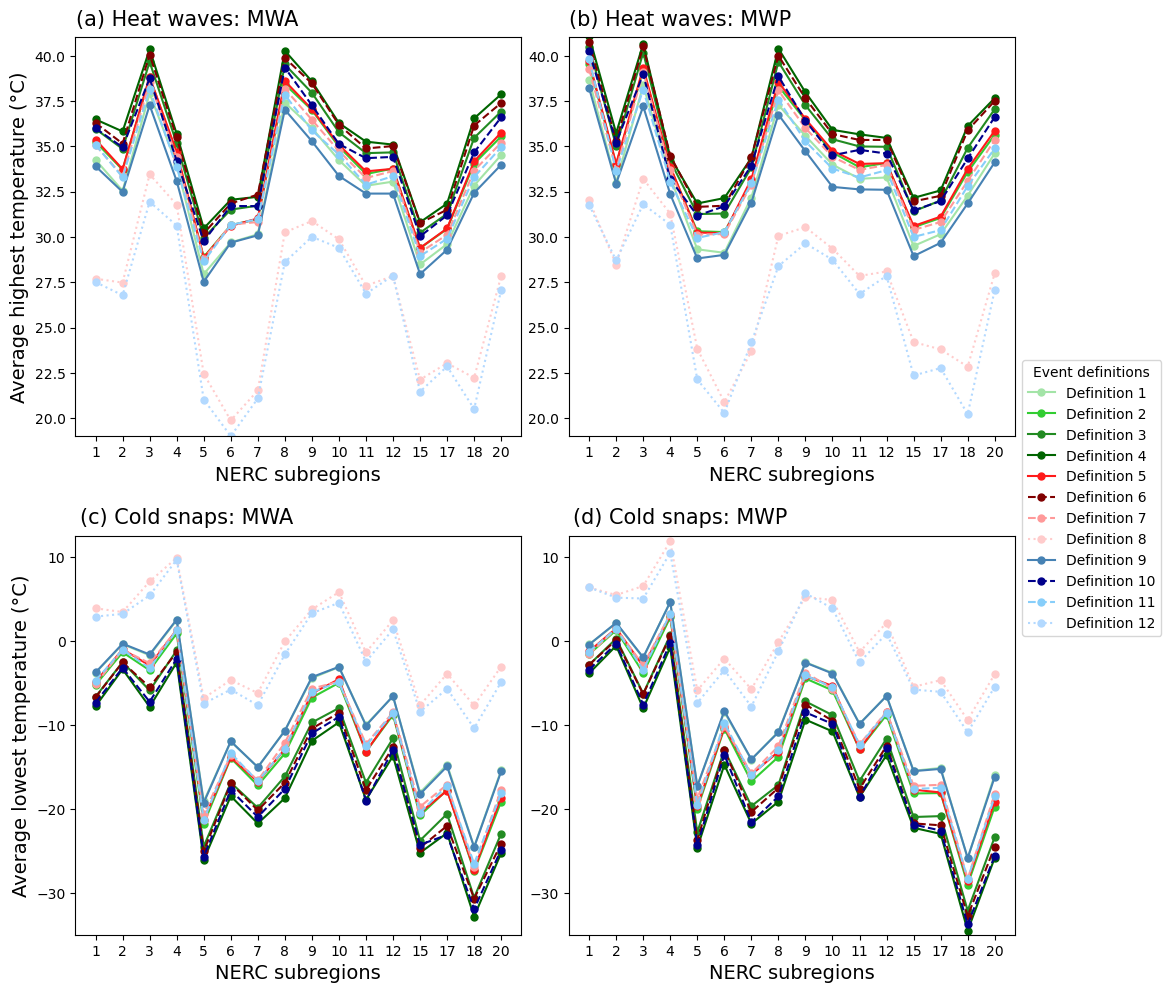

In [238]:
## Plot the extreme temperatures for each NERC subregion under different definitions
# Create the plots using the updated color, line styles, and smaller marker size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Define the marker size you want (e.g., 5)
marker_size = 5

# Subplot 1: grouped_area for heat waves
for idx, column in enumerate(grouped_hw_area.columns):
    axes[0, 0].plot(grouped_hw_area.index, grouped_hw_area[column], marker='o', label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 0].set_ylabel('Average highest temperature (°C)', fontsize=14)
axes[0, 0].set_ylim([19, 41])
axes[0, 0].set_xlabel('NERC subregions', fontsize=14)
axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area.index])
axes[0, 0].text(0.25, 1.07, '(a) Heat waves: MWA', size=15, ha='center', va='top', transform=axes[0, 0].transAxes)  # Adjusted to be closer below

# Subplot 2: grouped_pop for heat waves
for idx, column in enumerate(grouped_hw_pop.columns):
    axes[0, 1].plot(grouped_hw_pop.index, grouped_hw_pop[column], marker='o', label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 1].set_ylim([19, 41])
axes[0, 1].set_xlabel('NERC subregions', fontsize=14)
axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop.index])
axes[0, 1].text(0.25, 1.07, '(b) Heat waves: MWP', size=15, ha='center', va='top', transform=axes[0, 1].transAxes)  # Adjusted to be closer below

# Subplot 3: grouped_area for cold snaps
for idx, column in enumerate(grouped_cs_area.columns):
    axes[1, 0].plot(grouped_cs_area.index, grouped_cs_area[column], marker='o', label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 0].set_ylabel('Average lowest temperature (°C)', fontsize=14)
axes[1, 0].set_ylim([-35, 12.5])
axes[1, 0].set_xlabel('NERC subregions', fontsize=14)
axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area.index])
axes[1, 0].text(0.25, 1.07, '(c) Cold snaps: MWA', size=15, ha='center', va='top', transform=axes[1, 0].transAxes)  # Adjusted to be closer below

# Subplot 4: grouped_pop for cold snaps
for idx, column in enumerate(grouped_cs_pop.columns):
    axes[1, 1].plot(grouped_cs_pop.index, grouped_cs_pop[column], marker='o', label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 1].set_ylim([-35, 12.5])
axes[1, 1].set_xlabel('NERC subregions', fontsize=14)
axes[1, 1].set_xticklabels([extract_number(x) for x in grouped_cs_pop.index])
axes[1, 1].text(0.25, 1.07, '(d) Cold snaps: MWP', size=15, ha='center', va='top', transform=axes[1, 1].transAxes)  # Adjusted to be closer below

# Use the handles and labels from one subplot for the legend
handles, labels = axes[0, 0].get_legend_handles_labels()

# Create one common legend for the figure with unique labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), ncol=1, title='Event definitions')

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout()
plt.subplots_adjust(right=0.85, hspace=0.25)  # Adjust the right parameter to make space for the legend

# plt.savefig("Figure 2.tif", format="tif", dpi=300)
# Show the plot
plt.show()


# Plot the event frequency (count)

In [241]:
# Grouping and sorting event count for each dataset
grouped_hw_area_count = group_and_sort_data(all_hw_area, group_by_column='definition', 
                                        index_column_name='NERC_ID', operation='count')

grouped_hw_pop_count = group_and_sort_data(all_hw_pop, group_by_column='definition', 
                                       index_column_name='NERC_ID', operation='count')

grouped_cs_area_count = group_and_sort_data(all_cs_area, group_by_column='definition', 
                                        index_column_name='NERC_ID', operation='count')

grouped_cs_pop_count = group_and_sort_data(all_cs_pop, group_by_column='definition', 
                                       index_column_name='NERC_ID', operation='count')

C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1382868944.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area_count.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1382868944.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop_count.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1382868944.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area_count.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\1382868944.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of tic

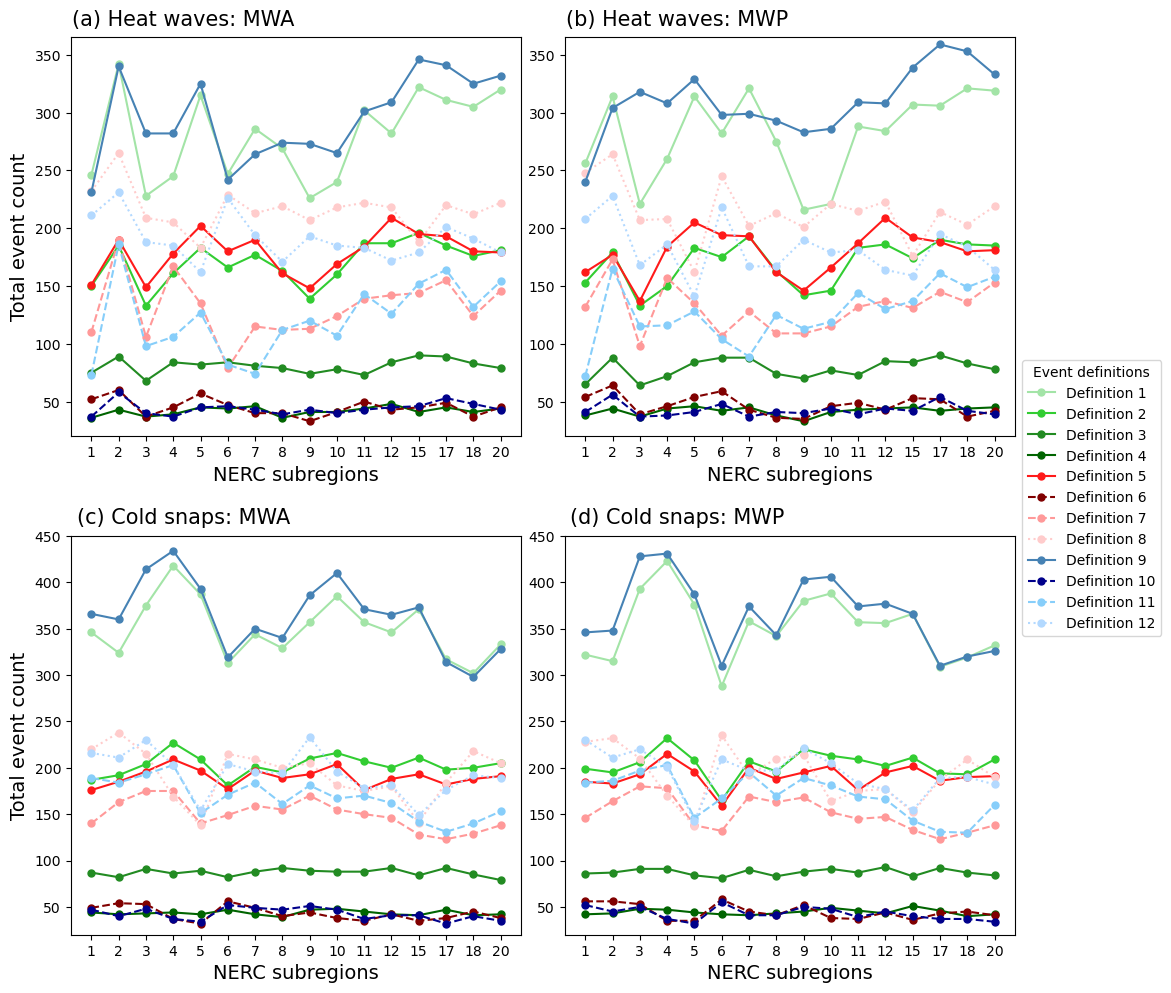

In [243]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Define the marker size you want (e.g., 5)
marker_size = 5

# Subplot 1: grouped_area for heat waves
for idx, column in enumerate(grouped_hw_area_count.columns):
    axes[0, 0].plot(grouped_hw_area_count.index, grouped_hw_area_count[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 0].set_ylabel('Total event count', fontsize = 14)
axes[0, 0].set_ylim([20, 365])
axes[0, 0].set_xlabel('NERC subregions', fontsize = 14)
axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area_count.index])
axes[0, 0].text(0.25, 1.07, '(a) Heat waves: MWA', size=15, ha='center', va='top', transform=axes[0, 0].transAxes)

# Subplot 2: grouped_pop for heat waves
for idx, column in enumerate(grouped_hw_pop_count.columns):
    axes[0, 1].plot(grouped_hw_pop_count.index, grouped_hw_pop_count[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 1].set_ylim([20, 365])
axes[0, 1].set_xlabel('NERC subregions', fontsize = 14)
axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop_count.index])
axes[0, 1].text(0.25, 1.07, '(b) Heat waves: MWP', size=15, ha='center', va='top', transform=axes[0, 1].transAxes)

# Subplot 3: grouped_area for cold snaps
for idx, column in enumerate(grouped_cs_area_count.columns):
    axes[1, 0].plot(grouped_cs_area_count.index, grouped_cs_area_count[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 0].set_ylabel('Total event count',  fontsize = 14)
axes[1, 0].set_ylim([20, 450])
axes[1, 0].set_xlabel('NERC subregions', fontsize = 14)
axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area_count.index])
axes[1, 0].text(0.25, 1.07, '(c) Cold snaps: MWA', size=15, ha='center', va='top', transform=axes[1, 0].transAxes)

# Subplot 4: grouped_pop for cold snaps
for idx, column in enumerate(grouped_cs_pop_count.columns):
    axes[1, 1].plot(grouped_cs_pop_count.index, grouped_cs_pop_count[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 1].set_ylim([20, 450])
axes[1, 1].set_xlabel('NERC subregions', fontsize = 14)
axes[1, 1].set_xticklabels([extract_number(x) for x in grouped_cs_pop_count.index])
axes[1, 1].text(0.25, 1.07, '(d) Cold snaps: MWP', size=15, ha='center', va='top', transform=axes[1, 1].transAxes)

# Use the handles and labels from one subplot for the legend
handles, labels = axes[0, 0].get_legend_handles_labels()

# Create one common legend for the figure with unique labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), ncol=1, title='Event definitions')

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout()
plt.subplots_adjust(right=0.85, hspace=0.25)  # Adjust the right parameter to make space for the legend

# plt.savefig("Figure 3.tif", format = "tif", dpi = 300)
# Show the plot
plt.show()

# Plot for duration (event days)

In [245]:
# Grouping, calculating mean of event duration, and sorting for each dataset
grouped_hw_area_day = group_and_sort_data(all_hw_area, group_by_column='definition', 
                                      index_column_name='NERC_ID', calculate_column='duration', operation='mean')

grouped_hw_pop_day = group_and_sort_data(all_hw_pop, group_by_column='definition', 
                                     index_column_name='NERC_ID', calculate_column='duration', operation='mean')

grouped_cs_area_day = group_and_sort_data(all_cs_area, group_by_column='definition', 
                                      index_column_name='NERC_ID', calculate_column='duration', operation='mean')

grouped_cs_pop_day = group_and_sort_data(all_cs_pop, group_by_column='definition', 
                                     index_column_name='NERC_ID', calculate_column='duration', operation='mean')

C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\4282452523.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area_day.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\4282452523.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop_day.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\4282452523.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area_day.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\4282452523.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.

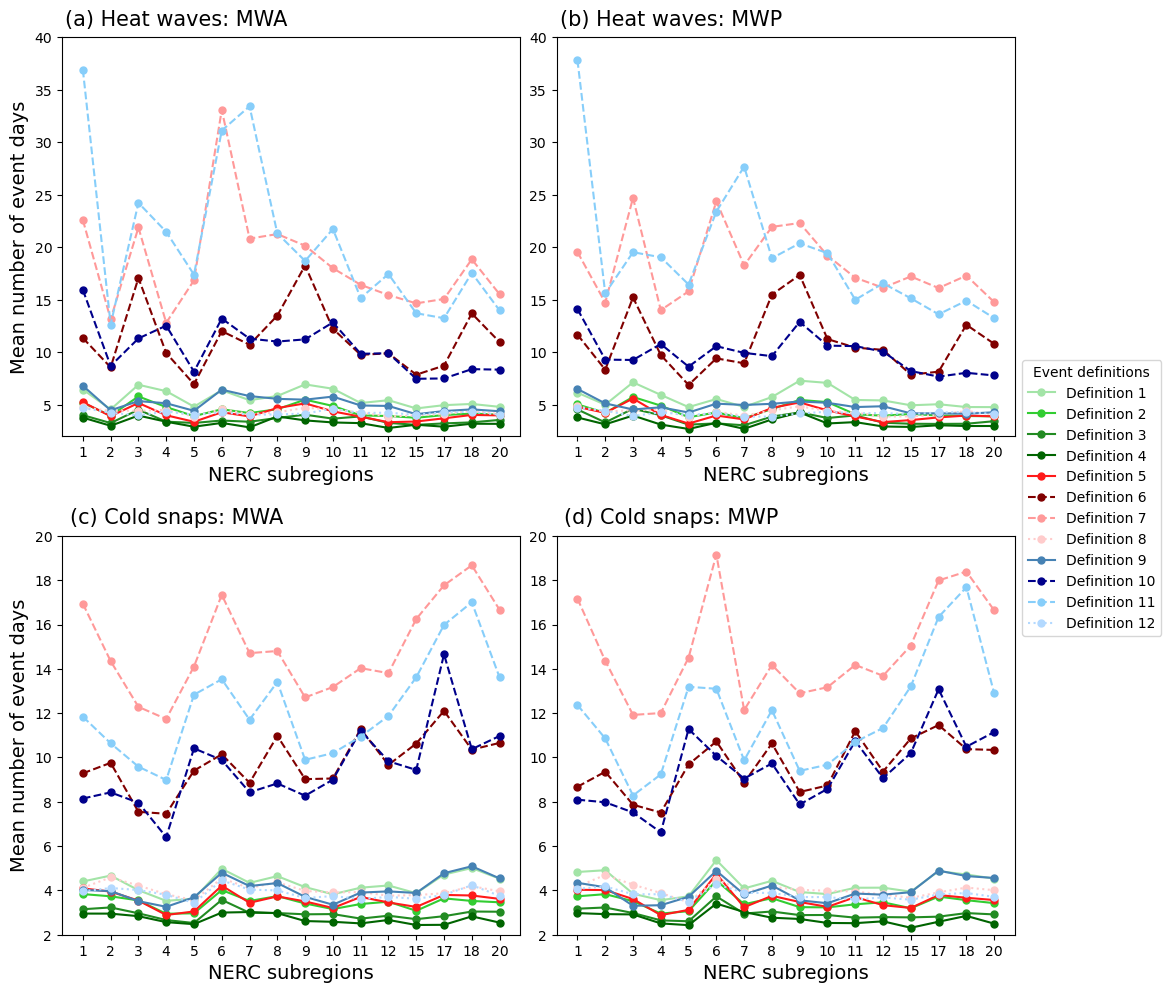

In [247]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Define the marker size you want (e.g., 5)
marker_size = 5

# Subplot 1: grouped_area for heat waves
for idx, column in enumerate(grouped_hw_area_day.columns):
    axes[0, 0].plot(grouped_hw_area_day.index, grouped_hw_area_day[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 0].set_ylabel('Mean number of event days', fontsize = 14)
axes[0, 0].set_ylim([2, 40])
axes[0, 0].set_xlabel('NERC subregions', fontsize = 14)
axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area_day.index])
axes[0, 0].text(0.25, 1.07, '(a) Heat waves: MWA', size=15, ha='center', va='top', transform=axes[0, 0].transAxes)

# Subplot 2: grouped_pop for heat waves
for idx, column in enumerate(grouped_hw_pop_day.columns):
    axes[0, 1].plot(grouped_hw_pop_day.index, grouped_hw_pop_day[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 1].set_ylim([2, 40])
axes[0, 1].set_xlabel('NERC subregions', fontsize = 14)
axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop_day.index])
axes[0, 1].text(0.25, 1.07, '(b) Heat waves: MWP', size=15, ha='center', va='top', transform=axes[0, 1].transAxes)

# Subplot 3: grouped_area for cold snaps
for idx, column in enumerate(grouped_cs_area_day.columns):
    axes[1, 0].plot(grouped_cs_area_day.index, grouped_cs_area_day[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 0].set_ylabel('Mean number of event days',  fontsize = 14)
axes[1, 0].set_ylim([2, 20])
axes[1, 0].set_xlabel('NERC subregions', fontsize = 14)
axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area_day.index])
axes[1, 0].text(0.25, 1.07, '(c) Cold snaps: MWA', size=15, ha='center', va='top', transform=axes[1, 0].transAxes)

# Subplot 4: grouped_pop for cold snaps
for idx, column in enumerate(grouped_cs_pop_day.columns):
    axes[1, 1].plot(grouped_cs_pop_day.index, grouped_cs_pop_day[column], marker='o', 
                    label=column, color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 1].set_ylim([2, 20])
axes[1, 1].set_xlabel('NERC subregions', fontsize = 14)
axes[1, 1].set_xticklabels([extract_number(x) for x in grouped_cs_pop_day.index])
axes[1, 1].text(0.25, 1.07, '(d) Cold snaps: MWP', size=15, ha='center', va='top', transform=axes[1, 1].transAxes)

# Use the handles and labels from one subplot for the legend
handles, labels = axes[0, 0].get_legend_handles_labels()

# Create one common legend for the figure with unique labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), ncol=1, title='Event definitions')

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout()
plt.subplots_adjust(right=0.85, hspace = 0.25)  # Adjust the right parameter to make space for the legend

# plt.savefig("Figure 4.tif", format = "tif", dpi = 300)
# Show the plot
plt.show()

# Plot for spatial coverage percentage

In [249]:
# Grouping, calculating mean of spatial coverage, and sorting for each dataset
grouped_hw_area_spa = group_and_sort_data(all_hw_area, group_by_column='definition', 
                                      index_column_name='NERC_ID', calculate_column='spatial_coverage', operation='mean')

grouped_hw_pop_spa = group_and_sort_data(all_hw_pop, group_by_column='definition', 
                                     index_column_name='NERC_ID', calculate_column='spatial_coverage', operation='mean')

grouped_cs_area_spa = group_and_sort_data(all_cs_area, group_by_column='definition', 
                                      index_column_name='NERC_ID', calculate_column='spatial_coverage', operation='mean')

grouped_cs_pop_spa = group_and_sort_data(all_cs_pop, group_by_column='definition', 
                                     index_column_name='NERC_ID', calculate_column='spatial_coverage', operation='mean')

C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\3644059144.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area_spa.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\3644059144.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop_spa.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\3644059144.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area_spa.index])
C:\Users\wanh535\AppData\Local\Temp\ipykernel_30992\3644059144.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.

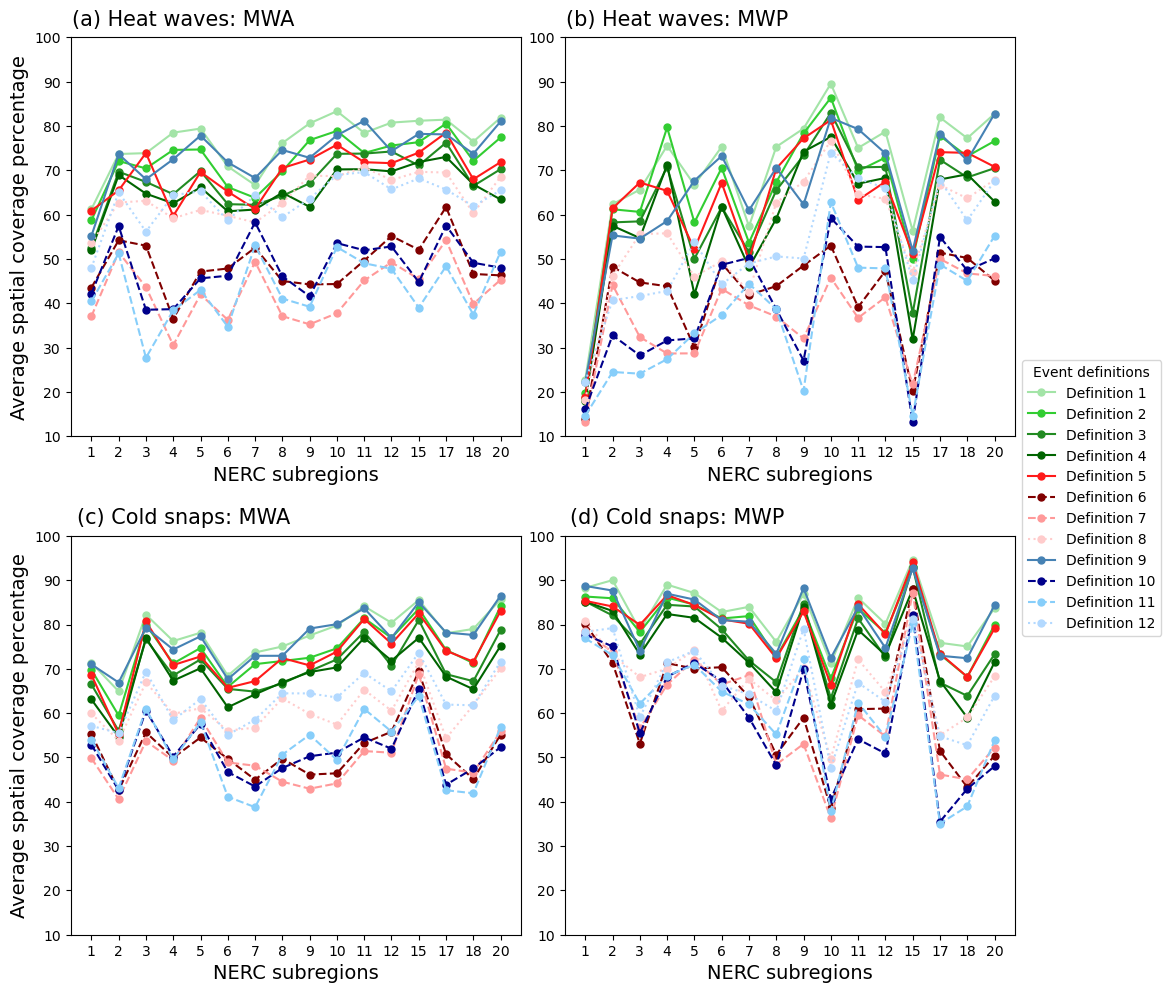

In [251]:
# Define the function to extract numbers
def extract_number(s):
    return re.findall(r'\d+', s)[0]

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Define the marker size you want (e.g., 5)
marker_size = 5

# Subplot 1: grouped_area for heat waves
for idx, column in enumerate(grouped_hw_area_spa.columns):
    axes[0, 0].plot(grouped_hw_area_spa.index, grouped_hw_area_spa[column], marker='o', label=column, 
                    color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 0].set_ylabel('Average spatial coverage percentage', fontsize = 14)
axes[0, 0].set_ylim([10, 100])
axes[0, 0].set_xlabel('NERC subregions', fontsize = 14)
axes[0, 0].set_xticklabels([extract_number(x) for x in grouped_hw_area_spa.index])
axes[0, 0].text(0.25, 1.07, '(a) Heat waves: MWA', size=15, ha='center', va='top', transform=axes[0, 0].transAxes)

# Subplot 2: grouped_pop for heat waves
for idx, column in enumerate(grouped_hw_pop_spa.columns):
    axes[0, 1].plot(grouped_hw_pop_spa.index, grouped_hw_pop_spa[column], marker='o', label=column, 
                    color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[0, 1].set_ylim([10, 100])
axes[0, 1].set_xlabel('NERC subregions', fontsize = 14)
axes[0, 1].set_xticklabels([extract_number(x) for x in grouped_hw_pop_spa.index])
axes[0, 1].text(0.25, 1.07, '(b) Heat waves: MWP', size=15, ha='center', va='top', transform=axes[0, 1].transAxes)

# Subplot 3: grouped_area for cold snaps
for idx, column in enumerate(grouped_cs_area_spa.columns):
    axes[1, 0].plot(grouped_cs_area_spa.index, grouped_cs_area_spa[column], marker='o', label=column, 
                    color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 0].set_ylabel('Average spatial coverage percentage',  fontsize = 14)
axes[1, 0].set_ylim([10, 100])
axes[1, 0].set_xlabel('NERC subregions', fontsize = 14)
axes[1, 0].set_xticklabels([extract_number(x) for x in grouped_cs_area_spa.index])
axes[1, 0].text(0.25, 1.07, '(c) Cold snaps: MWA', size=15, ha='center', va='top', transform=axes[1, 0].transAxes)

# Subplot 4: grouped_pop for cold snaps
for idx, column in enumerate(grouped_cs_pop_spa.columns):
    axes[1, 1].plot(grouped_cs_pop_spa.index, grouped_cs_pop_spa[column], marker='o', label=column, 
                    color=custom_colors[idx], linestyle=linestyles[idx], markersize=marker_size)
axes[1, 1].set_ylim([10, 100])
axes[1, 1].set_xlabel('NERC subregions', fontsize = 14)
axes[1, 1].set_xticklabels([extract_number(x) for x in grouped_cs_pop_spa.index])
axes[1, 1].text(0.25, 1.07, '(d) Cold snaps: MWP', size=15, ha='center', va='top', transform=axes[1, 1].transAxes)

# Use the handles and labels from one subplot for the legend
handles, labels = axes[0, 0].get_legend_handles_labels()

# Create one common legend for the figure with unique labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), ncol=1, title='Event definitions')

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout()
plt.subplots_adjust(right=0.85, hspace=0.25)  # Adjust the right parameter to make space for the legend

# plt.savefig("Figure 5.tif", format = "tif", dpi = 300)
# Show the plot
plt.show()